In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/opt/slh/icecube/')

import os
#os.environ["CUDA_VISIBLE_DEVICES"]="1,0"
os.environ["CUDA_VISIBLE_DEVICES"]="1"
#os.environ["NCCL_P2P_DISABLE"] = "1"

In [2]:
import polars as pl
import pandas as pd
import gc
import os
import numpy as np
from icecube.models import EncoderWithDirectionReconstructionV8
from fastai_fix import *

/opt/conda/lib/python3.7/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /opt/conda/lib/python3.7/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


graphnet: INFO     2023-03-03 16:05:47 - get_logger - Writing log to logs/graphnet_20230303-160547.log


In [3]:
OUT = 'init'
PATH = '../data/'

NUM_WORKERS = 20
SEED = 2023
bs = 512
L = 192

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)
os.makedirs(OUT, exist_ok=True)

In [4]:
import torch, random
from typing import Iterator, Iterable, Optional, Sequence, List, TypeVar, Generic, Sized, Union

class RandomChunkSampler(torch.utils.data.Sampler[int]):
    r"""Samples elements randomly. If without replacement, then sample from a shuffled dataset.
    If with replacement, then user can specify :attr:`num_samples` to draw.
    Args:
        data_source (Dataset): dataset to sample from
        replacement (bool): samples are drawn on-demand with replacement if ``True``, default=``False``
        num_samples (int): number of samples to draw, default=`len(dataset)`.
        generator (Generator): Generator used in sampling.
    """
    data_source: Sized
    replacement: bool

    def __init__(self, data_source: Sized, num_samples: Optional[int] = None,
                 generator=None, chunk_size=200000, **kwargs) -> None:
        self.data_source = data_source
        self._num_samples = num_samples
        self.generator = generator
        self.chunk_size = chunk_size

        if not isinstance(self.num_samples, int) or self.num_samples <= 0:
            raise ValueError("num_samples should be a positive integer "
                             "value, but got num_samples={}".format(self.num_samples))

    @property
    def num_samples(self) -> int:
        # dataset size might change at runtime
        if self._num_samples is None:
            return len(self.data_source)
        return self._num_samples

    def __iter__(self) -> Iterator[int]:
        n = len(self.data_source)
        if self.generator is None:
            seed = int(torch.empty((), dtype=torch.int64).random_().item())
            generator = torch.Generator()
            generator.manual_seed(seed)
        else:
            generator = self.generator

        chunk_list = torch.randperm(self.num_samples // self.chunk_size, generator=generator).tolist()
        for i in range(self.num_samples // self.chunk_size):
            chunk = chunk_list[i]
            yield from (chunk*self.chunk_size + torch.randperm(self.chunk_size, generator=generator)).tolist()
        #yield from ((self.num_samples // self.chunk_size)*self.chunk_size + 
        #    torch.randperm(self.num_samples%self.chunk_size, generator=generator)).tolist()

    def __len__(self) -> int:
        return self.num_samples
    
class LenMatchBatchSampler(torch.utils.data.BatchSampler):
    def __iter__(self):
        buckets = [[]] * 100
        yielded = 0

        for idx in self.sampler:
            s = self.sampler.data_source[idx]
            if isinstance(s,tuple): L = s[0]["mask"].sum()
            else: L = s["mask"].sum()
            #if torch.rand(1).item() < 0.1: L = int(1.5*L)
            L = L // 16 
            if len(buckets[L]) == 0:  buckets[L] = []
            buckets[L].append(idx)
            
            if len(buckets[L]) == self.batch_size:
                batch = list(buckets[L])
                yield batch
                yielded += 1
                buckets[L] = []
                
        batch = []
        leftover = [idx for bucket in buckets for idx in bucket]

        for idx in leftover:
            batch.append(idx)
            if len(batch) == self.batch_size:
                yielded += 1
                yield batch
                batch = []

        if len(batch) > 0 and not self.drop_last:
            yielded += 1
            yield batch

        #assert len(self) == yielded,\
        #  "produced an inccorect number of batches. expected %i, but yielded %i" %(len(self), yielded)

In [5]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import polars as pl
import pandas as pd
import os,gc
import numpy as np
from collections import OrderedDict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from scipy.interpolate import interp1d

def prepare_sensors(path=PATH):
    sensors = pd.read_csv(os.path.join(path,'sensor_geometry.csv')).astype(
        {
            "sensor_id": np.int16,
            "x": np.float32,
            "y": np.float32,
            "z": np.float32,
        }
    )
    sensors["string"] = 0
    sensors["qe"] = 0#1

    for i in range(len(sensors) // 60):
        start, end = i * 60, (i * 60) + 60
        sensors.loc[start:end, "string"] = i

        # High Quantum Efficiency in the lower 50 DOMs - https://arxiv.org/pdf/2209.03042.pdf (Figure 1)
        if i in range(78, 86):
            start_veto, end_veto = i * 60, (i * 60) + 10
            start_core, end_core = end_veto + 1, (i * 60) + 60
            sensors.loc[start_core:end_core, "qe"] = 1# 1.35

    # https://github.com/graphnet-team/graphnet/blob/b2bad25528652587ab0cdb7cf2335ee254cfa2db/src/graphnet/models/detector/icecube.py#L33-L41
    # Assume that "rde" (relative dom efficiency) is equivalent to QE
    sensors["x"] /= 500
    sensors["y"] /= 500
    sensors["z"] /= 500
    #sensors["qe"] -= 1.25
    #sensors["qe"] /= 0.25

    return sensors

def ice_transparency(path=PATH, datum=1950):
    # Data from page 31 of https://arxiv.org/pdf/1301.5361.pdf
    # Datum is from footnote 8 of page 29
    df = pd.read_csv(os.path.join(path,'ice_transparency.txt'), delim_whitespace=True)
    df["z"] = df["depth"] - datum
    df["z_norm"] = df["z"] / 500
    df[["scattering_len_norm", "absorption_len_norm"]] = RobustScaler().fit_transform(
        df[["scattering_len", "absorption_len"]])

    # These are both roughly equivalent after scaling
    f_scattering = interp1d(df["z_norm"], df["scattering_len_norm"])
    f_absorption = interp1d(df["z_norm"], df["absorption_len_norm"])
    return f_scattering, f_absorption

class IceCubeDataset(Dataset):
    def __init__(self, path=PATH, chunk_size=200000, L=256, buf_size=4, train=True, reduce_size=-1):
        #path_geometry=PATH_GEOMETRY, /sensor_geometry.csv
        self.path = os.path.join(path,'train')
        self.files = [p for p in sorted(os.listdir(self.path)) if p!='batch_660.parquet'] #660 is shorter
        val_fnames = ['batch_655.parquet','batch_656.parquet','batch_657.parquet','batch_658.parquet',
                      'batch_659.parquet']
        if not train: self.files = val_fnames
        else: self.files = sorted(set(self.files) - set(val_fnames))
        self.chunk_size = chunk_size
        self.buf = OrderedDict()
        self.L,self.buf_size = L,buf_size
        sensors = prepare_sensors(path)
        self.geometry = torch.from_numpy(sensors[['x','y','z']].values.astype(np.float32))
        self.qe = sensors['qe'].values
        self.ice_properties = ice_transparency(path)
        
        df = pd.read_parquet(os.path.join(path,'train_meta.parquet'))
        df = df[['event_id','azimuth','zenith']]
        df['azimuth'] = df['azimuth'].astype(np.float32)
        df['zenith'] = df['zenith'].astype(np.float32)
        df['event_id'] = df['event_id'].astype(np.int32)
        df = df.set_index('event_id',drop=True)
        self.target = df
        gc.collect()
        self.reduce_size = reduce_size
        
    def __len__(self):
        return len(self.files)*self.chunk_size if self.reduce_size < 0 \
                else int(self.reduce_size*len(self.files))*self.chunk_size
        
    def __getitem__(self, idx0):
        fname = self.files[idx0//self.chunk_size]
        if fname not in self.buf:
            df = pl.read_parquet(os.path.join(self.path,fname))
            df = df.groupby("event_id").agg([
                pl.count(),
                pl.col("sensor_id").list(),
                pl.col("time").list(),
                pl.col("charge").list(),
                pl.col("auxiliary").list(),])
            self.buf[fname] = df.sort('event_id')
            if len(self.buf) > self.buf_size: del self.buf[list(self.buf.keys())[0]]
        
        idx = idx0%self.chunk_size
        df = self.buf[fname]
        sensor_id =  df[idx]['sensor_id'][0].item().to_numpy()
        time =  df[idx]['time'][0].item().to_numpy()
        charge = df[idx]['charge'][0].item().to_numpy()
        auxiliary = df[idx]['auxiliary'][0].item().to_numpy()
        event_idx = df[idx]['event_id'].item()
            
        #sensor_id = sensor_id[~auxiliary]
        #time = time[~auxiliary]
        #charge = charge[~auxiliary]
        
        time = (time - 1e4)/3e4
        charge = np.log10(charge)/3.0 #np.log(charge)
        
        L = len(sensor_id)
        if L < self.L:
            sensor_id = np.pad(sensor_id,(0,max(0,self.L-L)))
            time = np.pad(time,(0,max(0,self.L-L)))
            charge = np.pad(charge,(0,max(0,self.L-L)))
            auxiliary = np.pad(auxiliary,(0,max(0,self.L-L)))
        else:
            ids = torch.randperm(L).numpy()
            auxiliary_n = np.where(~auxiliary)[0]
            auxiliary_p = np.where(auxiliary)[0]
            ids_n = ids[auxiliary_n][:min(self.L,len(auxiliary_n))]
            ids_p = ids[auxiliary_p][:min(self.L-len(ids_n),len(auxiliary_p))]
            ids = np.concatenate([ids_n,ids_p])
            ids.sort()
            L = len(ids)
            
            sensor_id = sensor_id[ids]
            time = time[ids]
            charge = charge[ids]
            auxiliary = auxiliary[ids]
            L = len(ids)
            
        attn_mask = torch.zeros(self.L, dtype=torch.bool)
        attn_mask[:L] = True
        sensor_id = torch.from_numpy(sensor_id).long()
        pos = self.geometry[sensor_id]
        pos[L:] = 0
        qe = self.qe[sensor_id]
        qe[L:] = 0
        ice_properties = np.stack([self.ice_properties[0](pos[:L,2]),
                                   self.ice_properties[1](pos[:L,2])],-1)
        ice_properties = np.pad(ice_properties,((0,max(0,self.L-L)),(0,0)))
        ice_properties = torch.from_numpy(ice_properties).float()
        
        target = self.target.loc[event_idx].values

        return {'sensor_id': sensor_id, 'time': torch.from_numpy(time).float(),
                'charge': torch.from_numpy(charge).float(), 'pos':pos, 'mask':attn_mask,
                'idx':event_idx, 'auxiliary':torch.from_numpy(auxiliary).long(),
                'qe':qe, 'ice_properties':ice_properties},\
               {'target': torch.from_numpy(target).float()}
    
    
class IceCubeDataset_len(Dataset):
    def __init__(self, path=PATH, chunk_size=200000, L=256, buf_size=2, train=True, reduce_size=-1):
        #path_geometry=PATH_GEOMETRY, /sensor_geometry.csv
        self.path = os.path.join(path,'train')
        self.files = [p for p in sorted(os.listdir(self.path)) if p!='batch_660.parquet'] #660 is shorter
        val_fnames = ['batch_655.parquet','batch_656.parquet','batch_657.parquet','batch_658.parquet',
                      'batch_659.parquet']
        if not train: self.files = val_fnames
        else: self.files = sorted(set(self.files) - set(val_fnames))
        self.chunk_size = chunk_size
        self.buf = OrderedDict()
        self.L,self.buf_size = L,buf_size
        sensors = prepare_sensors(path)
        self.geometry = torch.from_numpy(sensors[['x','y','z']].values.astype(np.float32))
        self.qe = sensors['qe'].values
        self.ice_properties = ice_transparency(path)
        
        gc.collect()
        self.reduce_size = reduce_size
        
    def __len__(self):
        return len(self.files)*self.chunk_size if self.reduce_size < 0 \
                else int(self.reduce_size*len(self.files))*self.chunk_size
        
    def __getitem__(self, idx0):
        fname = self.files[idx0//self.chunk_size]
        if fname not in self.buf:
            df = pl.read_parquet(os.path.join(self.path,fname))
            df = df.groupby("event_id").agg([
                pl.count(),
                pl.col("sensor_id").list(),
                pl.col("time").list(),
                pl.col("charge").list(),
                pl.col("auxiliary").list(),])
            self.buf[fname] = df.sort('event_id')
            if len(self.buf) > self.buf_size: del self.buf[list(self.buf.keys())[0]]
        
        idx = idx0%self.chunk_size
        df = self.buf[fname]
        sensor_id =  df[idx]['sensor_id'][0].item().to_numpy()
        mask = torch.ones(min(len(sensor_id),self.L), dtype=torch.long)
        return {'mask':mask},{}

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as checkpoint
from timm.models.layers import drop_path, to_2tuple, trunc_normal_

from timm.models.layers import drop_path, to_2tuple, trunc_normal_

class DropPath(nn.Module):
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)
    
    def extra_repr(self) -> str:
        return 'p={}'.format(self.drop_prob)
    
class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        # x = self.drop(x)
        # commit this for the orignal BERT implement 
        x = self.fc2(x)
        x = self.drop(x)
        return x

#BEiTv2 block
class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., init_values=None, act_layer=nn.GELU, norm_layer=nn.LayerNorm,
                 window_size=None, attn_head_dim=None, **kwargs):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = nn.MultiheadAttention(dim, num_heads, dropout=drop, batch_first=True)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        if init_values is not None:
            self.gamma_1 = nn.Parameter(init_values * torch.ones((dim)),requires_grad=True)
            self.gamma_2 = nn.Parameter(init_values * torch.ones((dim)),requires_grad=True)
        else:
            self.gamma_1, self.gamma_2 = None, None

    def forward(self, x, attn_mask=None, key_padding_mask=None):
        if self.gamma_1 is None:
            xn = self.norm1(x)
            x = x + self.drop_path(self.attn(xn,xn,xn,
                            attn_mask=attn_mask,
                            key_padding_mask=key_padding_mask,
                            need_weights=False)[0])
            x = x + self.drop_path(self.mlp(self.norm2(x)))
        else:
            xn = self.norm1(x)
            x = x + self.drop_path(self.gamma_1 * self.drop_path(self.attn(xn,xn,xn,
                            attn_mask=attn_mask,
                            key_padding_mask=key_padding_mask,
                            need_weights=False)[0]))
            x = x + self.drop_path(self.gamma_2 * self.mlp(self.norm2(x)))
        return x

class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim=16, M=10000):
        super().__init__()
        self.dim = dim
        self.M = M

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(self.M) / half_dim
        emb = torch.exp(torch.arange(half_dim, device=device) * (-emb))
        emb = x[...,None] * emb[None,...]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

class Extractor(nn.Module):
    def __init__(self, dim_base=128, dim=384):
        super().__init__()
        self.emb = SinusoidalPosEmb(dim=dim_base)
        self.emb2 = SinusoidalPosEmb(dim=dim_base//2)
        self.aux_emb = nn.Embedding(2,dim_base//2)
        self.qe_emb = nn.Embedding(2,dim_base//2)
        self.proj = nn.Linear(dim_base*7,dim)
        
    def forward(self, x, Lmax=None):
        pos = x['pos'] if Lmax is None else x['pos'][:,:Lmax]
        charge = x['charge'] if Lmax is None else x['charge'][:,:Lmax]
        time = x['time'] if Lmax is None else x['time'][:,:Lmax]
        auxiliary = x['auxiliary'] if Lmax is None else x['auxiliary'][:,:Lmax]
        qe = x['qe'] if Lmax is None else x['qe'][:,:Lmax]
        ice_properties = x['ice_properties'] if Lmax is None else x['ice_properties'][:,:Lmax]
        
        x = torch.cat([self.emb(100*pos).flatten(-2), self.emb(40*charge),
                       self.emb(100*time),self.aux_emb(auxiliary),self.qe_emb(qe),
                       self.emb2(50*ice_properties).flatten(-2)],-1)
        x = self.proj(x)
        return x

class DeepIceModel(nn.Module):
    def __init__(self, dim=384, dim_base=128, depth=12, use_checkpoint=False, **kwargs):
        super().__init__()
        self.extractor = Extractor(dim_base,dim)
        self.cls_token = nn.Linear(dim,1,bias=False)
        self.blocks = nn.ModuleList([ 
            Block(
                dim=dim, num_heads=dim//64, mlp_ratio=4, drop_path=0, init_values=1,)
            for i in range(depth)])
        #self.blocks = nn.ModuleList([ 
        #    nn.TransformerEncoderLayer(dim,dim//64,dim*4,dropout=0,
        #        activation=nn.GELU(), batch_first=True, norm_first=True)
        #    for i in range(depth)])

        self.proj_out = nn.Linear(dim,3)
        self.use_checkpoint = use_checkpoint
        self.apply(self._init_weights)
        trunc_normal_(self.cls_token.weight, std=.02)

    def fix_init_weight(self):
        def rescale(param, layer_id):
            param.div_(math.sqrt(2.0 * layer_id))

        for layer_id, layer in enumerate(self.blocks):
            rescale(layer.attn.proj.weight.data, layer_id + 1)
            rescale(layer.mlp.fc2.weight.data, layer_id + 1)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def init_weights(self, pretrained=None):
        def _init_weights(m):
            if isinstance(m, nn.Linear):
                trunc_normal_(m.weight, std=.02)
                if isinstance(m, nn.Linear) and m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.bias, 0)
                nn.init.constant_(m.weight, 1.0)
        self.apply(_init_weights)
    
    def forward(self, x0):
        mask = x0['mask']
        B,_ = mask.shape
        mask = torch.cat([torch.ones(B,1,dtype=mask.dtype, device=mask.device),mask],1)
        attn_mask = torch.zeros(mask.shape, device=mask.device)
        attn_mask[~mask] = -torch.inf
        Lmax = mask.sum(-1).max()
        
        x = self.extractor(x0, Lmax-1)
        cls_token = self.cls_token.weight.unsqueeze(0).expand(B,-1,-1)
        x = torch.cat([cls_token,x],1)
        x,mask,attn_mask = x[:,:Lmax], mask[:,:Lmax], attn_mask[:,:Lmax]
        
        #Lmax = mask.max(0)[0].sum()
        Lmax = mask.sum(-1).max()
        x,mask,attn_mask = x[:,:Lmax], mask[:,:Lmax], attn_mask[:,:Lmax]
        #print(Lmax)
        
        for blk in self.blocks:
            if self.use_checkpoint:
                x = checkpoint.checkpoint(blk, x, None, attn_mask)
            else: x = blk(x, None, attn_mask)
                
        x = self.proj_out(x[:,0]) #cls token
        return x

In [7]:
import math
from loss_functions import VonMisesFisher3DLoss

def loss(pred,y):
    #print(pred.max())
    pred = F.normalize(pred.float(),dim=-1)
    
    sa2 = torch.sin(y['target'][:,0])
    ca2 = torch.cos(y['target'][:,0])
    sz2 = torch.sin(y['target'][:,1])
    cz2 = torch.cos(y['target'][:,1])
    
    scalar_prod = (pred[:,0]*sa2*sz2 + pred[:,1]*ca2*sz2 + pred[:,2]*cz2).clip(-1+1e-8,1-1e-8)
    return torch.acos(scalar_prod).abs().mean(-1)   

def loss_vms(pred,y):
    sa2 = torch.sin(y['target'][:,0])
    ca2 = torch.cos(y['target'][:,0])
    sz2 = torch.sin(y['target'][:,1])
    cz2 = torch.cos(y['target'][:,1])
    t = torch.stack([sa2*sz2,ca2*sz2,cz2],-1)
    
    p = pred.float()
    l = torch.norm(pred.float(),dim=-1).unsqueeze(-1)
    p = torch.cat([pred.float()/l,l],-1)
    
    loss = VonMisesFisher3DLoss()(p,t)
    return loss

def get_val(pred):
    pred = F.normalize(pred,dim=-1)
    zen = torch.acos(pred[:,2].clip(-1,1))
    f = F.normalize(pred[:,:2],dim=-1)
    az = torch.asin(f[:,0].clip(-1,1))
    az = torch.where(f[:,1] > 0, az, math.pi - az)
    az = torch.where(az > 0, az, az + 2.0*math.pi)
    return torch.stack([az,zen],-1)

In [8]:
def dict_to(x, device='cuda'):
    return {k:x[k].to(device) for k in x}

def to_device(x, device='cuda'):
    return tuple(dict_to(e,device) for e in x)

class DeviceDataLoader:
    def __init__(self, dataloader, device='cuda'):
        self.dataloader = dataloader
        self.device = device
    
    def __len__(self):
        return len(self.dataloader)
    
    def __iter__(self):
        for batch in self.dataloader:
            yield tuple(dict_to(x, self.device) for x in batch)
            
def WrapperAdamW(param_groups,**kwargs):
    return OptimWrapper(param_groups,torch.optim.AdamW)

In [9]:
fname = 'init5small'

ds_train = IceCubeDataset(train=True, reduce_size=0.125, L=L)
ds_train_len = IceCubeDataset_len(train=True, reduce_size=0.125, L=L)
len_sampler_train = LenMatchBatchSampler(RandomChunkSampler(ds_train_len),batch_size=bs, drop_last=True)
dl_train = DeviceDataLoader(DataLoader(ds_train, batch_sampler=len_sampler_train, num_workers=4, 
                        persistent_workers=True))
#dl_train = DeviceDataLoader(DataLoader(ds_train, batch_size=bs, sampler=RandomChunkSampler(ds_train),
#                            num_workers=8, persistent_workers=True, drop_last=True))
#there is a bug in process pool creation, so persistent_workers and num_workers=0 are important
ds_val = IceCubeDataset(train=False, L=L)
ds_val_len = IceCubeDataset_len(train=False, L=L)
len_sampler_val = LenMatchBatchSampler(RandomChunkSampler(ds_val_len),batch_size=bs, drop_last=False)
dl_val = DeviceDataLoader(DataLoader(ds_val, batch_sampler=len_sampler_val, num_workers=0))
#dl_val= DeviceDataLoader(DataLoader(ds_val, batch_size=bs, sampler=RandomChunkSampler(ds_val),
#                            num_workers=0, drop_last=False))

data = DataLoaders(dl_train,dl_val)
model = EncoderWithDirectionReconstructionV8()
model = model.cuda()
learn = Learner(data, model, loss_func=loss_vms,cbs=[GradientClip(3.0),
            SaveModelCallback(monitor='loss',comp=np.less,at_end=True),
            GradientAccumulation(n_acc=4)],
            metrics=[loss], opt_func=partial(WrapperAdamW,eps=1e-7)).to_fp16()



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:63: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


SuggestedLRs(valley=3.981071586167673e-06)

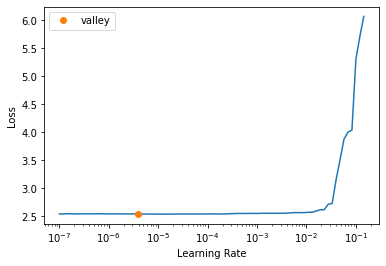

In [10]:
learn.lr_find()

In [11]:
learn.fit_one_cycle(8, lr_max=5e-4, wd=0.05, pct_start=0.01)
torch.save(learn.model.state_dict(),os.path.join(OUT,f'{fname}_0.pth'))
#torch.save(learn.model.module.state_dict(),os.path.join(OUT,f'{fname}_0.pth'))

epoch,train_loss,valid_loss,loss,time
0,1.629674,1.578753,1.042175,2:42:10
1,1.563874,1.540420,1.030785,2:43:18
2,1.539338,1.504885,1.024979,2:44:05
3,1.501985,1.488280,1.020265,2:44:30
4,1.497736,1.479548,1.012755,2:44:37
5,1.443593,1.426972,1.001136,2:44:20
6,1.402677,1.397596,0.994404,2:44:25
7,1.414280,1.391022,0.991815,2:44:22


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:63: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Better model found at epoch 0 with loss value: 1.0421749353408813.
Better model found at epoch 1 with loss value: 1.030785083770752.
Better model found at epoch 2 with loss value: 1.0249793529510498.
Better model found at epoch 3 with loss value: 1.0202646255493164.
Better model found at epoch 4 with loss value: 1.012755274772644.


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Better model found at epoch 5 with loss value: 1.001136064529419.
Better model found at epoch 6 with loss value: 0.9944040179252625.
Better model found at epoch 7 with loss value: 0.9918146729469299.


AttributeError: 'EncoderWithDirectionReconstructionV8' object has no attribute 'module'

In [12]:
torch.save(learn.model.state_dict(),os.path.join(OUT,f'{fname}_0.pth'))

In [13]:
os.path.join(OUT,f'{fname}_0.pth')

'init/init5small_0.pth'